# Проект: Исследование A/A/B-эксперимента

Стартап по продаже продуктов питания поставил задачу изучить поведение пользователей мобильного приложения.

Задачами проекта станут изучение воронки продаж, определение проблемных мест, а также анализ эксперимента дизайнеров компании по смене шрифта мобильного приложения. 

В ходе проекта будет проведена подготовка и очистка данных. 

Затем будет проведен исследовательский анализ данных, построена и проанализирована воронка событий.

Заключительным шагом проекта станет анализ проведенного эксперимента и оценка его результатов. 

## Подготовка данных

### Импорт библиотек и ознакомление с данными

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import math as mth
from datetime import datetime
from scipy import stats as st
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

Создадим и изучим датафрейм

In [2]:
data = pd.read_csv('C:\\Users\\user\\Downloads\\Портфолио\\logs_exp.csv', sep= '\t')

In [3]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Из документации известно, что: 

в столбце EventName содержатся названия событий,

в столбце DeviceIDHash содержатся уникальные идентификаторы пользователей, 

в столбце EventTimestamp содержится время события,

в столбце ExpId содержатся номера экспериментов 246 и 247 — контрольные группы, а 248 — экспериментальная,


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Столбец с временем события имеет некорректный формат, необходимо это исправить.

In [5]:
data['datetime'] = pd.to_datetime(data['EventTimestamp'], unit='s')

In [6]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId,datetime
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


Добавим столбец с датой

In [61]:
data['date'] = data['datetime'].dt.date
data.head()

,event_name,user_id,timestamp,group,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Переименуем столбцы для удобства работы

In [8]:
data.columns = ['event_name', 'user_id', 'timestamp', 'group', 'datetime', 'date']
data.head()

,event_name,user_id,timestamp,group,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


### Поиск пропусков и дубликатов

Изучим данные на предмет пропусков

In [9]:
data.isna().sum()

event_name    0
user_id       0
timestamp     0
group         0
datetime      0
date          0
dtype: int64

Изучим данные на предмет явных дубликатов и избавимся от них

In [10]:
data.duplicated().sum()

413

In [11]:
data = data.drop_duplicates()

In [12]:
data.duplicated().sum()

0

Рассмотрим уникальные значения столбцов, где вероятно обнаружение неявных дубликатов

In [13]:
data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [14]:
data['group'].unique()

array([246, 248, 247], dtype=int64)

### Промежуточный вывод: 

В рамках первого этапа было проведено первичное ознакомление с данными.

Формат столбца со временем события был изменен на корректный. 

Был добавлен столбец с датой события.

Пропусков не было обнаружено.

Были найдены и удалены явные дубликаты, неявные не были обнаружены. 

## Изучение данных

### Общее ознакомление, подсчет событий, пользователей, определение границ исследуемого периода

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   timestamp   243713 non-null  int64         
 3   group       243713 non-null  int64         
 4   datetime    243713 non-null  datetime64[ns]
 5   date        243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 13.0+ MB


Подсчитаем общее количество событий

In [63]:
data['event_name'].count()

243713

Подсчитаем количество событий в разбивке по названию события

In [17]:
data.groupby('event_name')['event_name'].count().sort_values(ascending=False)

event_name
MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Подсчитаем количество уникальных пользователей

In [18]:
data['user_id'].nunique()

7551

Подсчитаем среднее количество событий на пользователя

In [19]:
round(data.groupby('user_id').agg({'event_name':'count'}).mean(), 2)

event_name    32.28
dtype: float64

Определим границы исследуемого периода, найдем максимальную и минимульную даты

In [20]:
data['date'].max()

datetime.date(2019, 8, 7)

In [21]:
data['date'].min()

datetime.date(2019, 7, 25)

### Проверка полноты данных

Создадим таблицу и график с количеством событий в разбивке по группам и датам

In [22]:
events_by_date = data.pivot_table(index='date', columns='group', values='event_name', aggfunc='count')
events_by_date

group,246,247,248
date,,,
2019-07-25,4,1,4
2019-07-26,14,8,9
2019-07-27,24,23,8
2019-07-28,33,36,36
2019-07-29,55,58,71
2019-07-30,129,138,145
2019-07-31,620,664,746
2019-08-01,11561,12306,12274
2019-08-02,10946,10990,13618


<Axes: xlabel='date'>

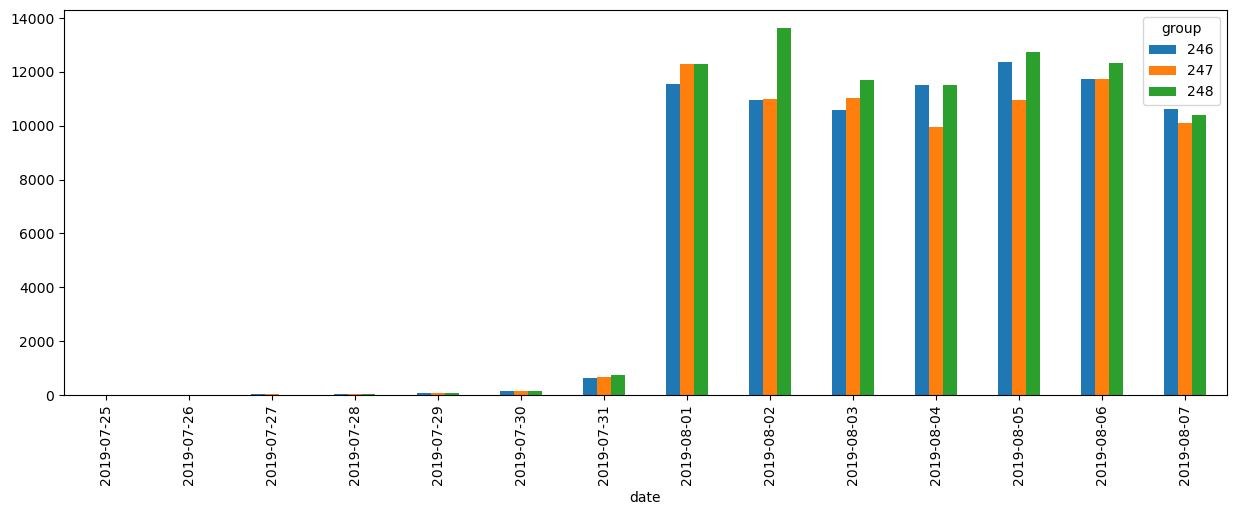

In [23]:
events_by_date.plot(kind='bar', figsize=(15,5))

### Отсечение неполных данных, оценка потерь

Из таблицы и графика видно, что данные до 2019-08-01 неполные, для дальнейшего анализа имеет смысл их отсечь

In [24]:
data_filtered = data[data['datetime'] >= '2019-08-01 00:00:00']
data_filtered.head()

,event_name,user_id,timestamp,group,datetime,date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


Удостоверимся, что в внесении изменений 

<Axes: xlabel='date'>

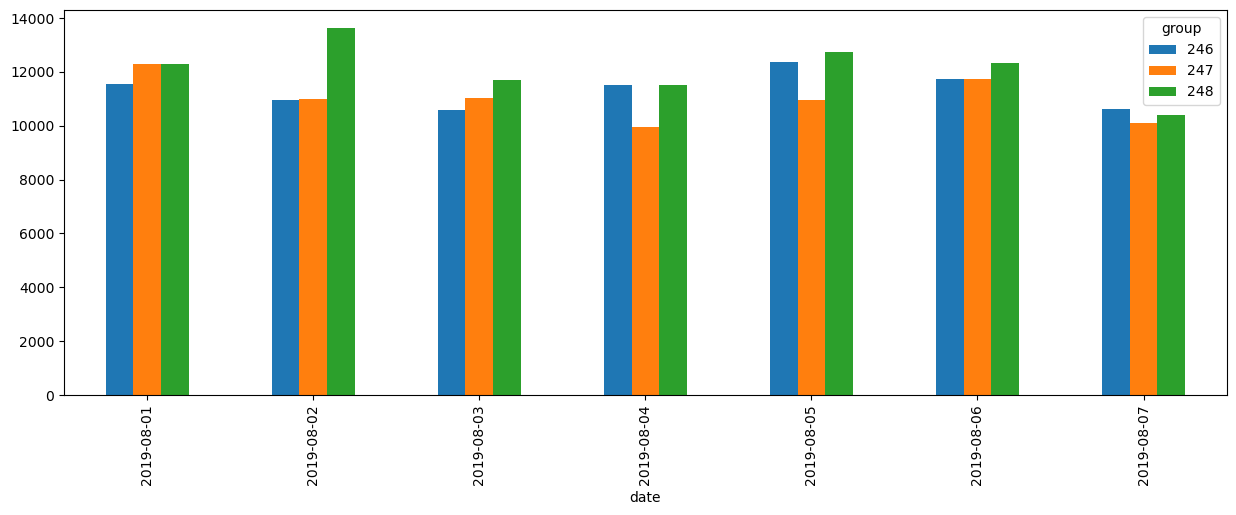

In [25]:
filtered_events_by_date = data_filtered.pivot_table(index='date', columns='group', values='event_name', aggfunc='count')

filtered_events_by_date.plot(kind='bar', figsize=(15,5))

In [26]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240887 entries, 2828 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  240887 non-null  object        
 1   user_id     240887 non-null  int64         
 2   timestamp   240887 non-null  int64         
 3   group       240887 non-null  int64         
 4   datetime    240887 non-null  datetime64[ns]
 5   date        240887 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 12.9+ MB


Снова подсчитаем количество событий в разбивке по названию события

In [27]:
data_filtered.groupby('event_name')['event_name'].count().sort_values(ascending=False)

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Оценим масштаб потерь

In [28]:
old_events = data['event_name'].count()
new_events = data_filtered['event_name'].count()
events_loss = round(((old_events - new_events) * 100 / old_events), 2)
f'Общее число потерь составило {old_events - new_events} строк - {events_loss}%'

'Общее число потерь составило 2826 строк - 1.16%'

In [29]:
old_users = data['user_id'].nunique()
new_users = data_filtered['user_id'].nunique()
users_loss = round(((old_users - new_users) * 100 / old_users), 2)
f'Общее число потерь пользователей составило {old_users - new_users} строк - {users_loss}%'

'Общее число потерь пользователей составило 17 строк - 0.23%'

Потери в рамках допустимой нормы

Проверим наличие пользователей во всех группах 

In [30]:
data_filtered.groupby('group')['user_id'].nunique()

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

### Промежуточный вывод:

На этом этапе исследования было:

подсчитано общее число событий - 240887, 

подсчитано число событий в разбивке по названию:
        
        MainScreenAppear - 117328
        
        OffersScreenAppear - 46333
        
        CartScreenAppear - 42303
        
        PaymentScreenSuccessful - 33918
        
        Tutorial - 1005

подсчитано общее число уникальных пользователей - 7551, 

подсчитано среднее количество событий на пользователя - 32.28,

определены временные границы исследования  2019-07-25 - 2019-08-07.

проведена проверка полноты данных, лишние данные были отсечены, потери составили 1.16% от общего числа строк - в пределах нормы

##  Изучение воронки событий

Подсчитаем количество событий с разбивкой по названию 

In [31]:
events = data_filtered['event_name'].value_counts()
events

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: count, dtype: int64

Bизуализируем результат для наглядности

<Axes: xlabel='event_name'>

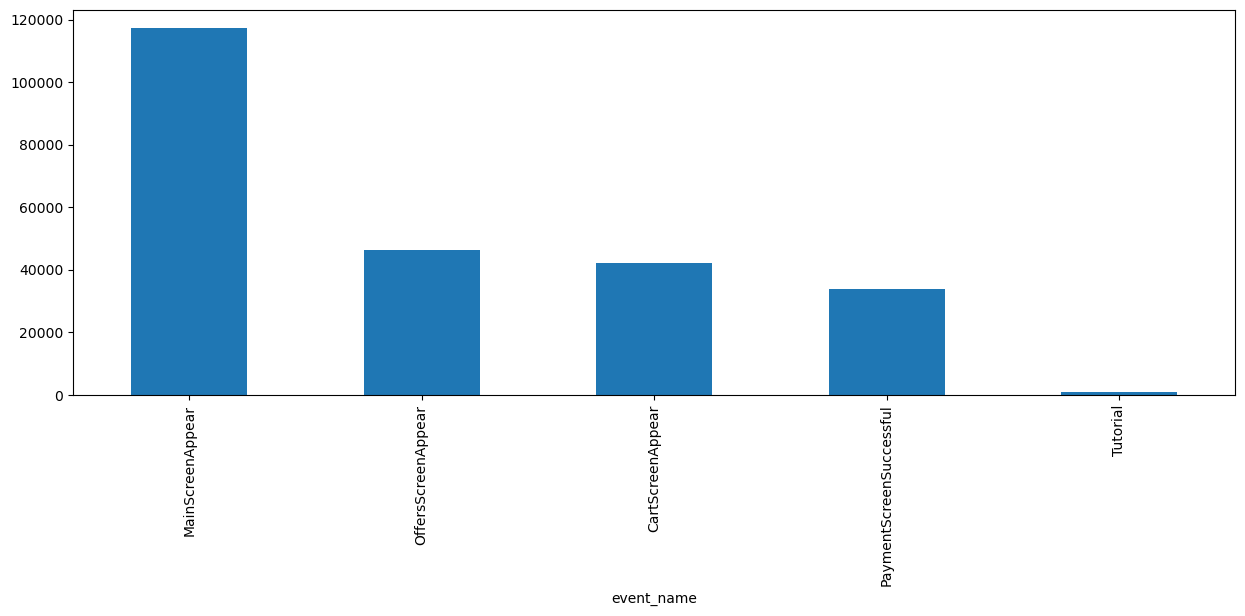

In [32]:
events.plot(kind='bar', figsize=(15,5))

Cоздадим воронку с указанием числа уникальных пользователей, совершавших событие и указанием доли от общего числа пользователей

In [33]:
display(f'Общее число пользователей: {new_users}')
funnel = data_filtered.pivot_table(index='event_name', values='user_id', 
                                   aggfunc='nunique').sort_values(by='user_id', ascending=False)
funnel['user_ratio'] = round(funnel['user_id'] / data_filtered['user_id'].nunique(), 2)
funnel.columns = ['users_per_event', 'percentage']
funnel

'Общее число пользователей: 7534'

,users_per_event,percentage
event_name,,
MainScreenAppear,7419,0.98
OffersScreenAppear,4593,0.61
CartScreenAppear,3734,0.50
PaymentScreenSuccessful,3539,0.47
Tutorial,840,0.11


Предположительно воронка выглядит так:

MainScreenAppear - отображение главного экрана

OffersScreenAppear - отображение экрана с предложениями

CartScreenAppear - отображение экрана корзины

PaymentScreenSuccessful - отображение экрана успешной оплаты

Tutorial - экран руководства пользователя 

Первые четыре этапа, вероятно, расположены последовательно и отражают путь пользователя от главной страницы до покупки, однако не вполне ясно, на каком этапе пользователю предлагается ознакомиться с руководством пользователя. Вероятно, это происходит до осуществления покупки. Также имеются некоторые сомнения относительно необходимости этого этапа для анализа. Далее она не будет приниматься в расчет при проведении анализа

Удалим строки с названием события "Tutorial"

In [34]:
data_filtered = data_filtered.query('event_name != "Tutorial"')
data_filtered.head()

,event_name,user_id,timestamp,group,datetime,date
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
2833,MainScreenAppear,4899590676214355127,1564618215,247,2019-08-01 00:10:15,2019-08-01


Количество потерь 1005 строк - так, суммарный объем потерь от общего объема данных составил 1,5%, все еще в пределах допустимого

Обновим воронку

In [35]:
funnel_upd = data_filtered.pivot_table(index='event_name', values='user_id', 
                                   aggfunc='nunique').sort_values(by='user_id', ascending=False)
funnel_upd['user_ratio'] = round(funnel_upd['user_id'] / data_filtered['user_id'].nunique(), 2)
funnel_upd.columns = ['users_per_event', 'percentage']
funnel_upd

,users_per_event,percentage
event_name,,
MainScreenAppear,7419,0.99
OffersScreenAppear,4593,0.61
CartScreenAppear,3734,0.50
PaymentScreenSuccessful,3539,0.47


Дополним воронку конверсией по шагам событие "MainScreenAppear" возьмем за единицу

In [36]:
display(f'Общее число пользователей: {new_users}')
funnel_upd['percentage_by_event'] = round(funnel['users_per_event'].sort_values() / funnel['users_per_event'].sort_values().shift(-1), 2)
funnel_upd = funnel_upd.fillna(1)
funnel_upd = funnel_upd.reset_index()
funnel_upd 

'Общее число пользователей: 7534'

,event_name,users_per_event,percentage,percentage_by_event
0,MainScreenAppear,7419,0.99,1.00
1,OffersScreenAppear,4593,0.61,0.62
2,CartScreenAppear,3734,0.50,0.81
3,PaymentScreenSuccessful,3539,0.47,0.95


Из имеющихся данных видно, что большая часть пользователей, отсеивается при переходе с главного экрана на экран с предложениями. Визуализируем воронку.

In [67]:
fig = px.funnel(funnel_upd, x='users_per_event', y='event_name')
fig.show()

In [39]:
f'Так, от общего числа пользователей до успешной покупки доходит порядка 47%, в то время как от первого экрана до покупки {round(3539/7419*100)}%' 

'Так, от общего числа пользователей до успешной покупки доходит порядка 47%, в то время как от первого экрана до покупки 48%'

### Промежуточный вывод: 

При изучении воронки событий было сформировано представление о предположительной последовательности событий: 

MainScreenAppear (oтображение главного экрана) -> OffersScreenAppear(отображение экрана с предложениями) -> CartScreenAppear (отображение экрана корзины) -> PaymentScreenSuccessful (отображение экрана успешной оплаты)

Также было принято решение пренебречь пятым типом событий tutorial(экран руководства пользователя), поскольку не удалось выявить прямой связи между ознакомлением с руководством пользователя и совершением покупки в приложении. Строки с этим событием были удалены, общий объем потерь - 1,5%, в рамках нормы. 

Затем была построена таблица воронки, содержащая данные о количестве уникальных пользователей, совершивших события, их доли от общего числа пользователей и конверсия в шаг, отражающая долю пользователей перешедших к следующему событию относительно предыдущего. 

Было обнаружено, что большая часть пользователей - порядка 38% отсеиваются при переходе с главного экрана на экран с предложениями. Так, от общего числа пользователей до успешной покупки доходит порядка 47%, в то время как от первого экрана до покупки 48%'

##  Изучение результатов теста

### Проведение A/A-теста

#### Подготовка к проведению теста

Для удобства проведения тестов было принято решение изменить названия групп на буквенные: 246 - А1, 247 - А2, 248 - В

In [40]:
data_filtered['group'] = data_filtered['group'].replace({246:'A1', 247:'A2', 248:'B'}) 
data_filtered.head()

,event_name,user_id,timestamp,group,datetime,date
2829,MainScreenAppear,3737462046622621720,1564618080,A1,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,A1,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,A1,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,A2,2019-08-01 00:08:59,2019-08-01
2833,MainScreenAppear,4899590676214355127,1564618215,A2,2019-08-01 00:10:15,2019-08-01


Проверим количество пользователей в группах и создадим совокупную контрольную группу А1+А2

In [41]:
users_by_group = data_filtered.groupby('group')['user_id'].nunique()
users_by_group['A1+A2'] = users_by_group['A1'] + users_by_group['A2']
users_by_group

group
A1       2483
A2       2512
B        2535
A1+A2    4995
Name: user_id, dtype: int64

Группы представляются соразмерными и пригодными для проведения теста

Также проверим возможную принадлежность пользователя к нескольким группам сразу

In [42]:
multiple_users = data_filtered.groupby('user_id').agg({'group':'nunique'})
multiple_users_count = multiple_users[multiple_users['group'] >= 2].count()
multiple_users_count

group    0
dtype: int64

Пользователей, состоящих в нескольких группах, не обнаружено

Построим таблицу для проведения теста

In [43]:
test_table = data_filtered.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').reset_index()
test_table['A1+A2'] = test_table['A1'] + test_table['A2']
test_table['total'] = test_table['A1'] + test_table['A2'] + test_table['B']
test_table = test_table.sort_values(by='total', ascending=False).reset_index(drop=True)
test_table

group,event_name,A1,A2,B,A1+A2,total
0,MainScreenAppear,2450,2476,2493,4926,7419
1,OffersScreenAppear,1542,1520,1531,3062,4593
2,CartScreenAppear,1266,1238,1230,2504,3734
3,PaymentScreenSuccessful,1200,1158,1181,2358,3539


#### Поиск разницы между контрольными выборками A1 и A2

Зададим функцию для проведения тестов

In [44]:
# функция имеет следующие параметры: группа 1, группа 2, уровень статистической значимости, название события
def z_test(group_1, group_2, alpha, event):
    # определим количество событий по группам 
    event_1 = test_table.loc[test_table['event_name'] == event, group_1]
    event_2 = test_table.loc[test_table['event_name'] == event, group_2]
    # подсчитаем количество пользователей в группе
    users_1 = users_by_group[group_1]
    users_2 = users_by_group[group_2]
    
    # определим пропорции
    p1 = event_1 / users_1
    p2 = event_2 / users_2
    
    p_combined = (event_1 + event_2) / (users_1 + users_2)
    
    
    z_value = (p1-p2)/mth.sqrt(p_combined *(1-p_combined) *(1/users_1 + 1/users_2))
    
    distr = st.norm(0,1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    # внесем поправку на количество экспериментов 4 группы по 4 события
    bonferroni_alpha = alpha / 16
    
    print('p-value:', p_value)
    
    if p_value < bonferroni_alpha:
        print('Нулевая гипотеза отвергается: между долями есть значимая разница')
    else:
        print('Нулевая гипотеза не отвергается: нет оснований считать доли разными')

Проведем А/A-тесты по всем четырем типам событий, критический уровень статистической значимости установим в 0.01, исходя из более жетских требований к А/А тесту.

Гипотезы во всех случаях идентичны:

Нулевая гипотеза: доли двух выборок равны

Альтернативная гипотеза: между долями есть значимая разница

In [45]:
z_test('A1', 'A2', 0.01, 'MainScreenAppear')

p-value: [0.75267034]
Нулевая гипотеза не отвергается: нет оснований считать доли разными


In [46]:
z_test('A1', 'A2', 0.01, 'OffersScreenAppear')

p-value: [0.24786097]
Нулевая гипотеза не отвергается: нет оснований считать доли разными


In [47]:
z_test('A1', 'A2', 0.01, 'CartScreenAppear')

p-value: [0.22867644]
Нулевая гипотеза не отвергается: нет оснований считать доли разными


In [48]:
z_test('A1', 'A2', 0.01, 'PaymentScreenSuccessful')

p-value: [0.11446628]
Нулевая гипотеза не отвергается: нет оснований считать доли разными


Во всех случаях p-value превысил критический уровень статистической значимости, что говорит об отсутствии оснований считать, что доли разные, группы можно считать контрольными.

### Проведение A1/B-теста

Проведем A/B тест по трем группам, двум А-группам в отдельности и совокупной. Уровень статистической значимости в этих тестах будет стандартным для таких тестов - 0.05 

In [49]:
z_test('A1', 'B', 0.05, 'MainScreenAppear')

p-value: [0.33871141]
Нулевая гипотеза не отвергается: нет оснований считать доли разными


In [50]:
z_test('A1', 'B', 0.05, 'OffersScreenAppear')

p-value: [0.21442477]
Нулевая гипотеза не отвергается: нет оснований считать доли разными


In [51]:
z_test('A1', 'B', 0.05, 'CartScreenAppear')

p-value: [0.08067368]
Нулевая гипотеза не отвергается: нет оснований считать доли разными


In [52]:
z_test('A1', 'B', 0.05, 'PaymentScreenSuccessful')

p-value: [0.21693034]
Нулевая гипотеза не отвергается: нет оснований считать доли разными


### Проведение A2/B-теста

In [53]:
z_test('A2', 'B', 0.05, 'MainScreenAppear')

p-value: [0.51949644]
Нулевая гипотеза не отвергается: нет оснований считать доли разными


In [54]:
z_test('A2', 'B', 0.05, 'OffersScreenAppear')

p-value: [0.93337513]
Нулевая гипотеза не отвергается: нет оснований считать доли разными


In [55]:
z_test('A2', 'B', 0.05, 'CartScreenAppear')

p-value: [0.58782846]
Нулевая гипотеза не отвергается: нет оснований считать доли разными


In [56]:
z_test('A2', 'B', 0.05, 'PaymentScreenSuccessful')

p-value: [0.72757187]
Нулевая гипотеза не отвергается: нет оснований считать доли разными


### Проведение A1+A2/B-теста

In [57]:
z_test('A1+A2', 'B', 0.05, 'MainScreenAppear')

p-value: [0.34866843]
Нулевая гипотеза не отвергается: нет оснований считать доли разными


In [58]:
z_test('A1+A2', 'B', 0.05, 'OffersScreenAppear')

p-value: [0.44582745]
Нулевая гипотеза не отвергается: нет оснований считать доли разными


In [59]:
z_test('A1+A2', 'B', 0.05, 'CartScreenAppear')

p-value: [0.18683559]
Нулевая гипотеза не отвергается: нет оснований считать доли разными


In [60]:
z_test('A1+A2', 'B', 0.05, 'PaymentScreenSuccessful')

p-value: [0.61079187]
Нулевая гипотеза не отвергается: нет оснований считать доли разными


Ни в одном из экспериментов не удалось опровергнуть нулевую гипотезу - не имеется оснований считать сравниваемые доли разными. Следовательно эксперимент по внедрению нового шрифта в приложении можно считать успешным - он не отпугнул пользователей. 

##  Выводы 


### Подготовка данных 

В ходе работы над проектом первым шагом стало ознакомление с предоставленными данными. 

В рамках этого этапа формат столбца, содержащего время события, был изменен на datetime для читаемости и удобства дальнейшей работы. Также был добавлен новый столбец, содержащий даты события. Данные были провены на предмет наличия пропусков и дубликатов - пропусков не было обнаружено, дубликаты были удалены.   

### Изучение данных

Следующим шагом стало более детальное изучение данных - были подсчитаны события, уникальные пользователи, определены временные границы собранных данных, также была проведена проверка полноты данных, лишние данные были удалены. 

Общее число событий составило 240887,

Число событий в разбивке по названию:

    MainScreenAppear - 117328

    OffersScreenAppear - 46333

    CartScreenAppear - 42303

    PaymentScreenSuccessful - 33918

    Tutorial - 1005

Число уникальных пользователей - 7551,

Среднее количество событий на пользователя - 32.28,

Временные границы исследования 2019-07-25 - 2019-08-07.

После отсечения данных, потери составили 1.16% от общего числа строк - допустимое значение. Общее число утраченных строк составило 2826,  общее число потерь пользователей составило 17 строк - 0.23%.

### Изучение воронки событий 

Третий этап исследования предполагал формирование и исследование воронки событий. 

При изучении воронки событий было сформировано представление о предположительной последовательности событий:

MainScreenAppear (oтображение главного экрана) -> OffersScreenAppear(отображение экрана с предложениями) -> CartScreenAppear (отображение экрана корзины) -> PaymentScreenSuccessful (отображение экрана успешной оплаты)

Было принято решение исключить событие tutorial(экран руководства пользователя) из исследования, поскольку не удалось выявить прямой связи между ознакомлением с руководством пользователя и совершением покупки в приложении. Строки с этим событием были удалены, общий объем потерь от исходного количества составил 1,5%.

Затем была построена таблица воронки, содержащая данные о количестве уникальных пользователей, совершивших события, их доли от общего числа пользователей и конверсия в шаг, отражающая долю пользователей перешедших к следующему событию относительно предыдущего.

Было обнаружено, что большая часть пользователей - порядка 38% отсеиваются при переходе с главного экрана на экран с предложениями.  Так, от общего числа пользователей до успешной покупки доходит порядка 47%, в то время как от первого экрана до покупки 48%. Команде стоит обратить внимание на высокие потери при переходе с главного экрана на второй этап совершнения покупки, необходимо установить причины такого поведения пользователей. 

### Изучение результатов теста 

В рамках заключительного этапа исследования был произведен ряд статистических тестов для ответа на вопрос о том, как обновленный шрифт в мобильном приложении сказывается на поведении пользователя. Пользователи были разбиты на 4 группы:

1. Контрольная группа - А1

2. Контрольная группа - А2 

3. Совокупная контрольная группа - А1+А2

4. Экспериментальная группа - B 

Всего было проведено 16 тестов - 4 группы по 4 событиям: MainScreenAppear (oтображение главного экрана) -> OffersScreenAppear(отображение экрана с предложениями) -> CartScreenAppear (отображение экрана корзины) -> PaymentScreenSuccessful (отображение экрана успешной оплаты). Во всех тестах применялись идентичные гипотезы: 

Нулевая гипотеза: доли двух выборок равны

Альтернативная гипотеза: между долями есть значимая разница

Первым был проведен A/A-тест для того, чтобы удостовериться, что контрольные группы составлены корректно. Проведенный тест не показал наличия существенной разницы между долями, что означает, что группы составлены корректно и могут использоваться в качестве контрольных. Статистическая значимость в этой серии тестов была определена как 0.01 по причине высоких требований к точности проведения А/А-тестов 

Затем был проведен ряд A/B тестов, по результатам которых также не удалось опровергнуть нулевые гипотезы, то есть тесты показали, что не имеется достаточных оснований полагать, что между долями имеется статистически значимая разница. Для А/B-тестов использовалась стандартная статистическая значимость в 0.05. 

Таким образом, можно прийти к выводу, что внедрение новых шрифтов не оказало статистически значимого эффекта на поведение пользователей и эксперимент можно считать успешным. 